In [19]:
import sentencepiece
from transformers import T5Tokenizer, T5EncoderModel

import torch
from datasets import load_dataset

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from umap import UMAP

import emoji

In [59]:
emojis = [
    # 😀 Smiles / Happiness / Fun
    "😀", "😃", "😄", "😁", "😆", "😅", "😂", "🤣", "😎", "😊",
    "😇", "😉", "😋", "😜", "🥳", "🤩", "😺", "😸", "😹", "😻",
    
    # 😢 Sad / Cry / Disappointed
    "😢", "😭", "😞", "😔", "😟", "😕", "🥺", "😩", "😫", "😖",
    
    # ❤️ Love / Affection
    "❤️", "💛", "💚", "💙", "💜", "🖤", "💔", "❣️", "💕", "💖",
    "💗", "💘", "💞", "💓", "💝",
    
    # 🤔 Thinking / Confused / Curious
    "🤔", "🤨", "😐", "😑", "😶", "😬", "😏", "🙄",
    
    # 😡 Anger / Frustration
    "😡", "😠", "🤯", "😤", "😒", "😾",
    
    # 🔥 Excitement / Hype / Energy
    "🔥", "💥", "✨", "⚡", "🌟", "🎉", "🎊",
    
    # 🥰 Affection / Cute / Positive Vibes
    "🥰", "😍", "😘", "😗", "😙", "😚", "😻", "🤗", "🤤",
    
    # 🐾 Animals / Nature
    "🐶", "🐱", "🐭", "🐹", "🐰", "🦊", "🐻", "🐼", "🐨", "🐯",
    "🦁", "🐮", "🐷", "🐸", "🐵", "🐔", "🐧", "🐦", "🐤", "🐣",
    
    # ⚽ Activities / Sports / Travel
    "⚽", "🏀", "🏈", "⚾", "🎾", "🏐", "🏉", "🏓", "🏸", "🏒",
    "✈️", "🚗", "🚕", "🚙", "🛵", "🚲", "🏖️", "🏔️", "🏕️",
    
    # 🍔 Food / Drinks
    "🍏", "🍎", "🍐", "🍊", "🍋", "🍌", "🍉", "🍇", "🍓", "🍒",
    "🥑", "🥦", "🥕", "🌽", "🥔", "🍠", "🍞", "🥐", "🥖", "🧀",
    "🍔", "🍟", "🍕", "🌭", "🥪", "🌮", "🌯", "🥗", "🍿", "🍩",
    
    # 🎶 Music / Entertainment
    "🎵", "🎶", "🎼", "🎤", "🎧", "🎷", "🎸", "🎹", "🥁", "🎺",
    
    # 🏠 Objects / Symbols / Misc
    "⌚", "📱", "💻", "🖥️", "🖨️", "🎮", "📷", "📹", "🔑", "💡",
    "💎", "📦", "🛒", "✏️", "📖", "📚", "📌", "🖊️", "🖋️"
]

set_emojis = set(emojis)

In [ ]:
df = pd.read_csv("backhand_index_pointing_right.csv",
engine="python",
encoding="utf-8",
on_bad_lines="skip", # or 'warn' to see which lines fail
quoting=1 # 1 = csv.QUOTE_NONE to ignore quotes
)


df = df.head(1000) # cut off
#df = df[df['Text'].apply(lambda t: any(e in t for e in set_emojis))].reset_index(drop=True)
#df = df[df['Text'].apply(lambda t: set(extract_emojis(t)).issubset(set_emojis))].reset_index(drop=True)

In [70]:
"""get all emojis from library"""

emoji_name_pairs = [
    (emj, meta.get('en', '').replace(":", "").replace("_", " "))
    for emj, meta in emoji.EMOJI_DATA.items()
    if 'en' in meta
]

In [ ]:
model_name = "KomeijiForce/t5-base-emojilm"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5EncoderModel.from_pretrained(model_name)

def extract_emojis(text):
    # Extracts all emojis in the text as a list of emoji characters
    return [e['emoji'] for e in emoji.emoji_list(text)]

def emoji_with_name(emj):
    name_colon = emoji.demojize(emj)
    # Clean to remove colons and replace underscores with spaces
    name_clean = name_colon.strip(":").replace("_", " ")
    return f"{emj} {name_clean}"

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling over token embeddings to get fixed-size vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

In [62]:
"""embeddings for emojis only"""

emoji_embeddings = {e: get_embedding(e) for e in emojis}

"""embeddings for emojis with description"""

emoji_embeddings_with_context = {e: get_embedding(emoji_with_name(e)) for e in emojis}

"""embeddings for emojis with tweets"""

emoji_embeddings_tweets = {
    e: np.mean(
        [get_embedding(f"{e} {t}") for t in df['Text'] if e in t],
        axis=0
    )
    for e in set(''.join(df['Text'].map(extract_emojis).sum()))
}

"""check for different embeddings"""
print((emoji_embeddings["😀"] - emoji_embeddings["🤩"])[0])
print((emoji_embeddings["😀"] - emoji_embeddings_with_context["😀"])[0])

-0.052678376
-0.032436013


In [63]:
def umap(emoji_embeddings):

    X = np.stack(list(emoji_embeddings.values()))
    labels = list(emoji_embeddings.keys())

    X_embedded = UMAP(n_components=1, random_state=42).fit_transform(X)

    plt.figure(figsize=(12, 2))
    plt.scatter(X_embedded[:, 0], np.zeros_like(X_embedded[:, 0]), s=50, alpha=0.7)

    for i, label in enumerate(labels):
        plt.text(
            X_embedded[i, 0],
            0,
            label,
            fontsize=15,
            ha='center',
            va='bottom'
        )

    plt.show()

    return X_embedded, labels

/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129395 (\N{FACE WITH PARTY HORN AND PARTY HAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph

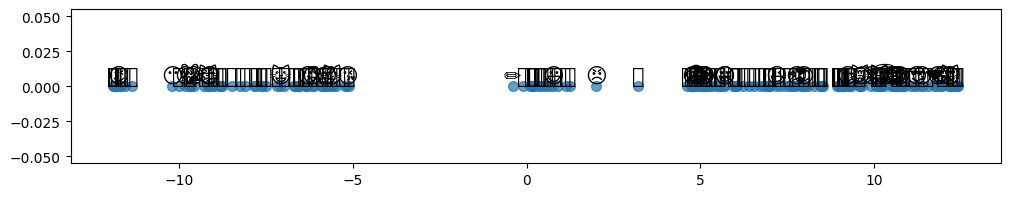

/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129395 (\N{FACE WITH PARTY HORN AND PARTY HAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph

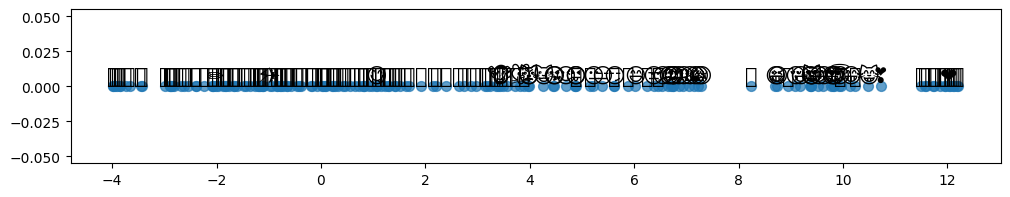

/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128158 (\N{REVOLVING HEARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128048 (\N{RABBIT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129395 (\N{FACE WITH PARTY HORN AND PARTY HAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/noah/order_emojis_ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129300 (\N{THINKING FACE}) mi

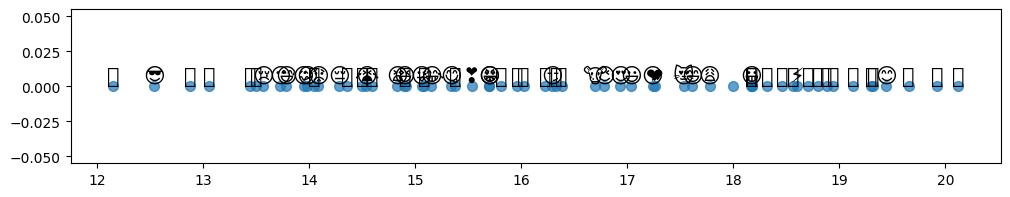

In [64]:
X_embedded, labels = umap(emoji_embeddings)
X_embedded_with_context, labels_with_context = umap(emoji_embeddings_with_context)
X_embedded_tweets, labels_tweets = umap(emoji_embeddings_tweets)

In [65]:
def ordering(X_embedded, labels):

    x_vals = X_embedded[:, 0]

    sorted_indices = x_vals.argsort()

    sorted_emojis = [labels[i] for i in sorted_indices]
    sorted_values = x_vals[sorted_indices]

    for emoji, val in zip(sorted_emojis, sorted_values):
        print(f"Emoji: {emoji} -> UMAP 1D value: {val:.4f}")

In [66]:
ordering(X_embedded, labels)

Emoji: 🐣 -> UMAP 1D value: -11.9126
Emoji: 🛒 -> UMAP 1D value: -11.8950
Emoji: 📹 -> UMAP 1D value: -11.8673
Emoji: 🍌 -> UMAP 1D value: -11.8205
Emoji: 😉 -> UMAP 1D value: -11.7600
Emoji: 🐹 -> UMAP 1D value: -11.7121
Emoji: 🏈 -> UMAP 1D value: -11.6817
Emoji: 🖊️ -> UMAP 1D value: -11.5606
Emoji: 🎾 -> UMAP 1D value: -11.3664
Emoji: 😶 -> UMAP 1D value: -10.2047
Emoji: 🍐 -> UMAP 1D value: -10.0216
Emoji: 😖 -> UMAP 1D value: -9.8282
Emoji: 🏐 -> UMAP 1D value: -9.7173
Emoji: 🐭 -> UMAP 1D value: -9.7009
Emoji: 🍇 -> UMAP 1D value: -9.6726
Emoji: 😭 -> UMAP 1D value: -9.5881
Emoji: 🎼 -> UMAP 1D value: -9.2915
Emoji: 😾 -> UMAP 1D value: -9.1862
Emoji: 🍟 -> UMAP 1D value: -9.1856
Emoji: 😑 -> UMAP 1D value: -9.1485
Emoji: 🍋 -> UMAP 1D value: -9.0258
Emoji: 💜 -> UMAP 1D value: -9.0041
Emoji: 🥑 -> UMAP 1D value: -8.8735
Emoji: 🍩 -> UMAP 1D value: -8.8014
Emoji: 🖨️ -> UMAP 1D value: -8.7827
Emoji: 🚕 -> UMAP 1D value: -8.4898
Emoji: 🤣 -> UMAP 1D value: -8.2508
Emoji: 🐸 -> UMAP 1D value: -8.1160
Emoji: 

In [67]:
ordering(X_embedded_with_context, labels_with_context)

Emoji: 🎺 -> UMAP 1D value: -3.9841
Emoji: 🥁 -> UMAP 1D value: -3.9755
Emoji: 🎵 -> UMAP 1D value: -3.9440
Emoji: 🎼 -> UMAP 1D value: -3.9106
Emoji: 🎹 -> UMAP 1D value: -3.8554
Emoji: 🎷 -> UMAP 1D value: -3.8481
Emoji: 🎧 -> UMAP 1D value: -3.7376
Emoji: 🎶 -> UMAP 1D value: -3.6632
Emoji: 🎤 -> UMAP 1D value: -3.4559
Emoji: 🎸 -> UMAP 1D value: -3.4322
Emoji: 🏸 -> UMAP 1D value: -2.9839
Emoji: 🏒 -> UMAP 1D value: -2.8988
Emoji: ⚽ -> UMAP 1D value: -2.8836
Emoji: 🏓 -> UMAP 1D value: -2.8729
Emoji: 🏐 -> UMAP 1D value: -2.8574
Emoji: ⚾ -> UMAP 1D value: -2.8092
Emoji: 🎾 -> UMAP 1D value: -2.6840
Emoji: 🏉 -> UMAP 1D value: -2.6277
Emoji: 🏀 -> UMAP 1D value: -2.5552
Emoji: 🐧 -> UMAP 1D value: -2.3990
Emoji: 🏈 -> UMAP 1D value: -2.3911
Emoji: 🖋️ -> UMAP 1D value: -2.2408
Emoji: 🖊️ -> UMAP 1D value: -2.0778
Emoji: 📹 -> UMAP 1D value: -2.0761
Emoji: 📚 -> UMAP 1D value: -2.0739
Emoji: ✏️ -> UMAP 1D value: -2.0141
Emoji: 🔑 -> UMAP 1D value: -1.9784
Emoji: 📷 -> UMAP 1D value: -1.8730
Emoji: 🖥️ -> UMAP

In [68]:
ordering(X_embedded_tweets, labels_tweets)

Emoji: 🤗 -> UMAP 1D value: 12.1527
Emoji: 😎 -> UMAP 1D value: 12.5399
Emoji: 💜 -> UMAP 1D value: 12.8769
Emoji: 🤤 -> UMAP 1D value: 13.0611
Emoji: 🌟 -> UMAP 1D value: 13.4428
Emoji: 🥺 -> UMAP 1D value: 13.5031
Emoji: 😢 -> UMAP 1D value: 13.5674
Emoji: 😶 -> UMAP 1D value: 13.7300
Emoji: 😅 -> UMAP 1D value: 13.7848
Emoji: 😖 -> UMAP 1D value: 13.9489
Emoji: 😕 -> UMAP 1D value: 13.9804
Emoji: 🙄 -> UMAP 1D value: 14.0483
Emoji: 😟 -> UMAP 1D value: 14.0838
Emoji: 😔 -> UMAP 1D value: 14.2852
Emoji: 💔 -> UMAP 1D value: 14.3586
Emoji: 🤔 -> UMAP 1D value: 14.5006
Emoji: 😭 -> UMAP 1D value: 14.5421
Emoji: 🎶 -> UMAP 1D value: 14.5986
Emoji: 😫 -> UMAP 1D value: 14.8329
Emoji: 😆 -> UMAP 1D value: 14.8960
Emoji: 🍊 -> UMAP 1D value: 14.9117
Emoji: 😜 -> UMAP 1D value: 15.0614
Emoji: 🤯 -> UMAP 1D value: 15.0862
Emoji: 😂 -> UMAP 1D value: 15.1532
Emoji: 😋 -> UMAP 1D value: 15.3408
Emoji: 💓 -> UMAP 1D value: 15.3803
Emoji: ❣ -> UMAP 1D value: 15.5357
Emoji: 😁 -> UMAP 1D value: 15.6962
Emoji: 😡 -> UMAP 1D 